In [1]:
from utils.autoencoder import AutoEncoder, train_autoencoder
from sklearn.metrics import classification_report
import pandas as pd
from utils.scoring import purity_score, score_clustering, clustering_classification_report
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from utils.spectral_clustering import score_spectral, extract_and_visualize_graph
from utils.clustering import score_dbscan, score_kmeans, fit_dbscan, fit_kmeans, extract_kmeans_cluster_labels, test_dbscan, tune_kmeans_dbscan
#from utils.SpectralNet import score_spectral_net
from utils.plotting import plot_2d_clusters
from xgboost import XGBClassifier
import warnings


warnings.filterwarnings('ignore')

# Load and preprocess data

In [2]:
data = pd.read_csv('creditcard.csv')
X = data.drop(['Class', 'Amount', 'Time'], axis=1)
y = data['Class']

X_scale = MinMaxScaler().fit_transform(X)

# sample data to reduce class imbalance
non_fraud_df = X_scale[y == 0][:2000]
fraud_df = X_scale[y == 1]

X_sample = np.vstack([non_fraud_df, fraud_df])
fraud_idx = np.zeros(len(X_sample))
fraud_idx[-len(fraud_df):] = 1

indices = np.arange(len(X_sample))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_sample, fraud_idx, indices, test_size=0.2, random_state=42, stratify=fraud_idx)

# Clustering on raw data

## Kmeans

In [3]:
cluster_metrics, classification_metrics = score_kmeans(X_train, X_test, y_train, y_test)
results_df = pd.DataFrame(cluster_metrics)
reports_df = pd.DataFrame(classification_metrics)

print(results_df.round(2))
reports_df.round(2)

   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.84       0.63       0.56     0.79      0.64      0.60
1           3      1.09       0.48       0.79     1.05      0.47      0.81
2           5      1.97       0.12       0.77     1.93      0.13      0.79
3          10      1.96       0.11       0.82     1.74      0.12      0.83


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.91,0.72,0.56,1.00,0.92,0.75,0.60,1.00
1,3,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
2,5,0.95,0.87,0.77,1.00,0.96,0.88,0.79,0.99
3,10,0.96,0.90,0.82,0.99,0.96,0.90,0.83,0.99


## DBSCAN

In [4]:
dbscan_cluster_metrics, dbscan_classification_metrics = score_dbscan(X_train, X_test, y_train, y_test)
dbscan_results_df = pd.DataFrame(dbscan_cluster_metrics)
dbscan_reports_df = pd.DataFrame(dbscan_classification_metrics)

print(dbscan_results_df.round(2))
dbscan_reports_df.round(2)

   eps  min_samples  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  \
0  0.2            5      1.87       0.31       0.83     1.93      0.25   
1  0.2           10      1.76       0.28       0.84     1.97      0.25   
2  0.3            5      1.31       0.61       0.23     1.16      0.61   
3  0.3           10      1.45       0.62       0.26     1.53      0.62   
4  0.4            5      0.90       0.57       0.02     0.30      0.55   
5  0.4           10      1.12       0.63       0.03     0.88      0.64   

   Test_Pur  
0      0.82  
1      0.82  
2      0.28  
3      0.31  
4      0.02  
5      0.03  


,eps,min_samples,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,0.2,5,0.96,0.89,0.84,0.94,0.95,0.86,0.85,0.88
1,0.2,10,0.96,0.90,0.86,0.94,0.94,0.86,0.85,0.87
2,0.3,5,0.85,0.38,0.23,0.97,0.86,0.44,0.28,0.97
3,0.3,10,0.85,0.41,0.26,0.97,0.86,0.47,0.31,0.97
4,0.4,5,0.81,0.04,0.02,0.89,0.81,0.04,0.02,1.00
5,0.4,10,0.81,0.06,0.03,0.92,0.81,0.06,0.03,1.00


# Spectral Clustering
With pairwise euclidean minimum distance from approximated train centroids to Xtest

In [5]:
spectral_cluster_metrics, spectral_classification_metrics = score_spectral(X_train, X_test, y_train, y_test)
spectral_cluster_results_df = pd.DataFrame(spectral_cluster_metrics)
spectral_cluster_reports_df = pd.DataFrame(spectral_classification_metrics)

print(spectral_cluster_results_df.round(2))
spectral_cluster_reports_df.round(2)

   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.57       0.69       0.19     0.60      0.69      0.37
1           3      0.98       0.57       0.78     0.90      0.59      0.78
2           5      0.96       0.57       0.77     0.90      0.59      0.78
3          10      1.02       0.56       0.80     0.95      0.58      0.82


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.84,0.32,0.19,1.00,0.88,0.54,0.37,1.0
1,3,0.96,0.88,0.78,1.00,0.96,0.88,0.78,1.0
2,5,0.95,0.87,0.78,0.99,0.96,0.88,0.78,1.0
3,10,0.96,0.89,0.80,1.00,0.96,0.90,0.82,1.0


In [6]:
# graph, plt_obj = extract_and_visualize_graph(X_train, y_train, affinity='rbf', gamma=1.0)
# plt_obj.show()

## SpectralNet

In [7]:
spectralnet_cluster_metrics, spectralnet_classification_metrics = score_spectral_net(X_train, X_test, y_train, y_test)
spectralnet_cluster_results_df = pd.DataFrame(spectralnet_cluster_metrics)
spectralnet_cluster_reports_df = pd.DataFrame(spectralnet_classification_metrics)

print(spectralnet_cluster_results_df.round(2))
spectralnet_cluster_reports_df.round(2)

Training SpectralNet:


Train Loss: 0.1026208, Valid Loss: 0.1649356, LR: 0.001000: 100%|██████████| 30/30 [00:03<00:00,  7.95it/s]


Training SpectralNet:


Train Loss: 0.4866607, Valid Loss: 1.5635267, LR: 0.000100: 100%|██████████| 30/30 [00:03<00:00,  8.51it/s]


Training SpectralNet:


Train Loss: 2.6633844, Valid Loss: 11.4138193, LR: 0.001000: 100%|██████████| 30/30 [00:03<00:00,  8.70it/s] 


Training SpectralNet:


Train Loss: 14.6339464, Valid Loss: 28.5341110, LR: 0.001000: 100%|██████████| 30/30 [00:03<00:00,  8.54it/s] 


   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.95       0.57       0.77     0.90      0.60      0.77
1           3      1.00       0.56       0.82     0.95      0.57      0.83
2           5      0.99       0.56       0.81     4.48      0.11      0.24
3          10      1.10       0.53       0.87     3.72      0.15      0.02


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.95,0.87,0.77,1.00,0.95,0.87,0.77,1.00
1,3,0.96,0.90,0.82,0.99,0.96,0.90,0.83,0.99
2,5,0.96,0.89,0.81,1.00,0.80,0.00,0.00,0.00
3,10,0.97,0.92,0.88,0.97,0.80,0.00,0.00,0.00


# Clustering on dimensionality reduced data

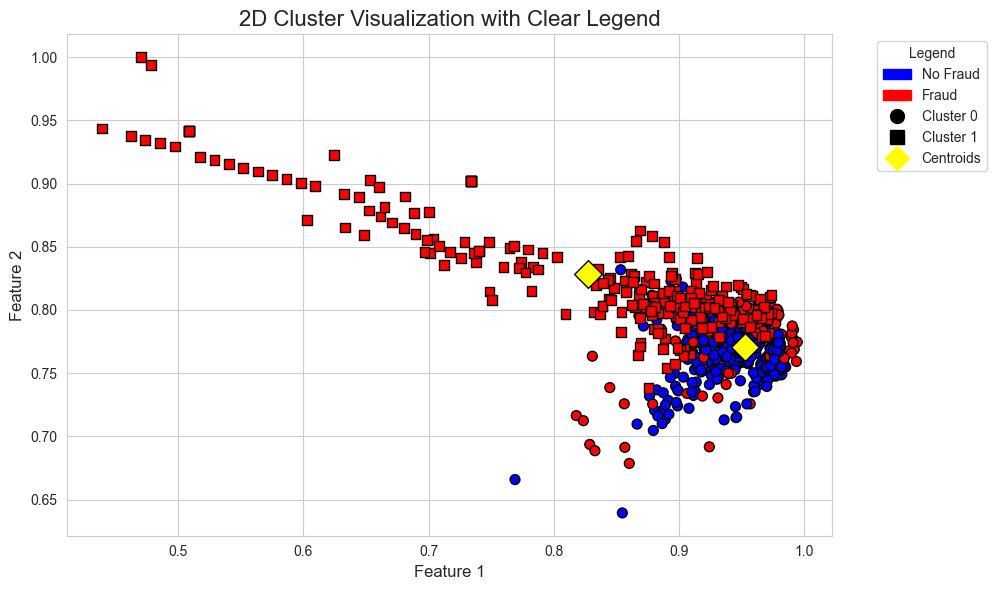

In [8]:
kmeans = fit_kmeans(X_train, 2)
train_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_train)

kmeans_centroids = kmeans.cluster_centers_

# Here the clusters are fitted in all dimensions but only first two are plotted
plot_2d_clusters(X_train, y_train, train_cluster_labels, kmeans_centroids)

## PCA



In [9]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_full_pca = pca.transform(X_scale)

### Kmeans

In [10]:
# find the optimal number of clusters
pca_clustering, pca_classification = score_kmeans(X_train_pca, X_test_pca, y_train, y_test)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(2))
pca_classification_df.round(2)

   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.51       0.81       0.56     0.49      0.82      0.60
1           3      0.63       0.78       0.79     0.54      0.78      0.81
2           5      0.83       0.42       0.79     0.78      0.43      0.81
3          10      0.74       0.43       0.86     0.78      0.42      0.89


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.91,0.72,0.56,1.00,0.92,0.75,0.60,1.00
1,3,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
2,5,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
3,10,0.97,0.91,0.87,0.95,0.97,0.92,0.90,0.95


   accuracy    f1  recall  precision
0       1.0  0.79    0.79       0.79


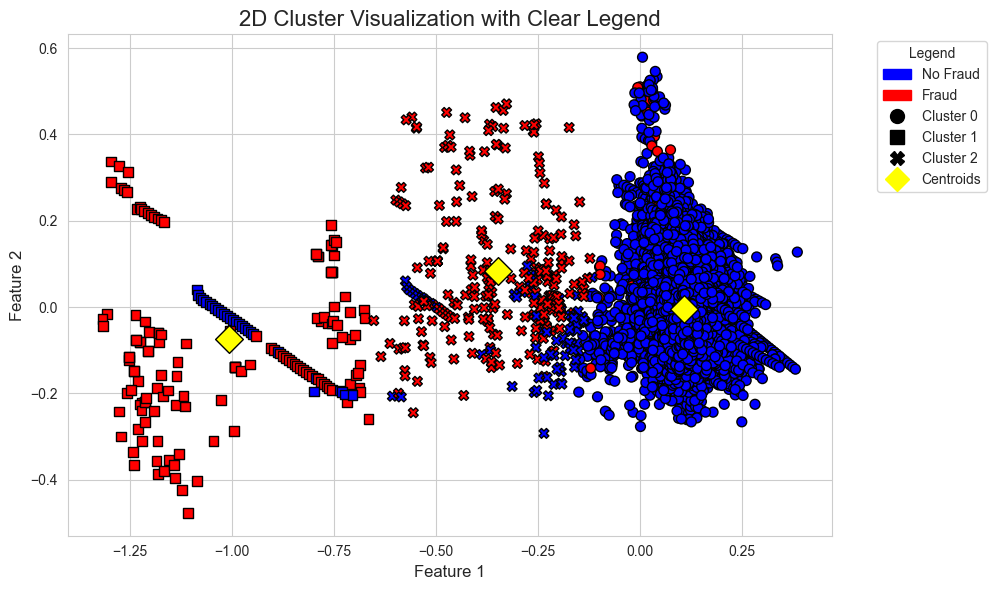

In [11]:
# test on full data
k = 3 # selected from the previous analysis
kmeans = fit_kmeans(X_train_pca, k)
full_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_full_pca)
full_kmeans_centroids = kmeans.cluster_centers_

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_pca, y, full_cluster_labels, full_kmeans_centroids)

### DBSCAN

In [12]:
# find the optimal number of clusters
eps = np.arange(0.05, 0.1, 0.005)
pca_clustering, pca_classification = score_dbscan(X_train_pca, X_test_pca, y_train, y_test, eps)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(3))
pca_classification_df.round(2)

     eps  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0  0.050     1.650      0.715      0.823    2.043     0.702     0.836
1  0.055     1.643      0.721      0.821    2.396     0.700     0.836
2  0.060     1.617      0.715      0.813    2.428     0.708     0.826
3  0.065     1.724      0.720      0.810    1.632     0.716     0.826
4  0.070     1.268      0.746      0.810    0.819     0.727     0.826
5  0.075     1.353      0.766      0.795    0.922     0.763     0.816
6  0.080     1.396      0.766      0.795    0.922     0.763     0.816
7  0.085     0.700      0.677      0.150    0.362     0.767     0.212
8  0.090     0.620      0.539      0.150    0.362     0.767     0.212
9  0.095     0.540      0.373      0.148    0.362     0.767     0.212


,eps,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,0.05,0.96,0.90,0.82,0.99,0.97,0.91,0.84,0.99
1,0.06,0.96,0.90,0.82,0.99,0.97,0.91,0.84,0.99
2,0.06,0.96,0.90,0.81,0.99,0.96,0.90,0.83,0.99
3,0.06,0.96,0.89,0.81,0.99,0.96,0.90,0.83,0.99
4,0.07,0.96,0.89,0.81,0.99,0.96,0.90,0.83,0.99
5,0.07,0.96,0.88,0.80,0.99,0.96,0.90,0.82,0.99
6,0.08,0.96,0.88,0.80,0.99,0.96,0.90,0.82,0.99
7,0.08,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00
8,0.09,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00
9,0.09,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00


   accuracy    f1  recall  precision
0       1.0  0.75    0.76       0.75


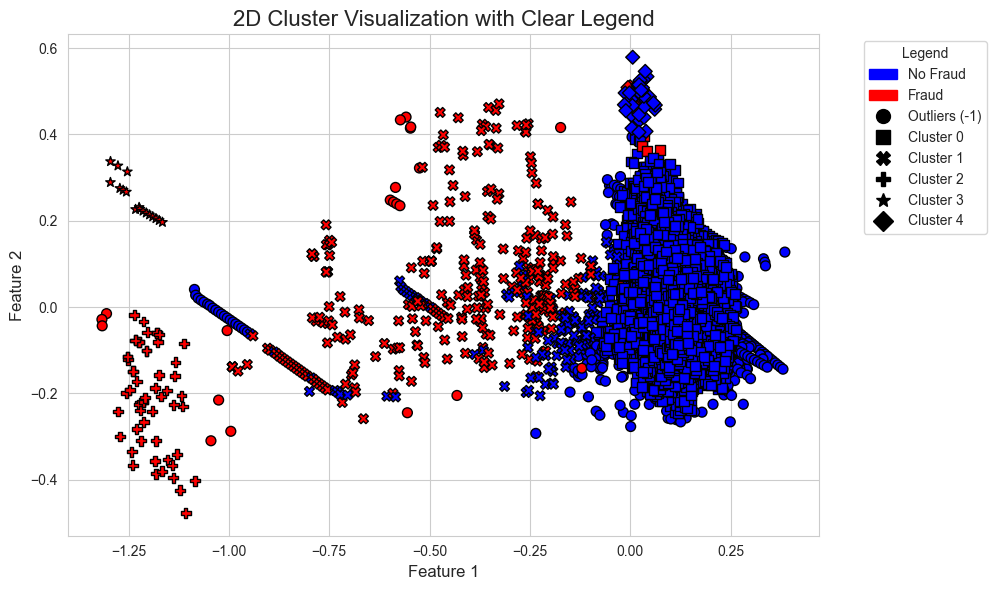

In [13]:
eps = 0.07
dbscan = fit_dbscan(X_train_pca, eps)

full_cluster_labels = test_dbscan(dbscan, X_train_pca, X_full_pca)

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_pca, y, full_cluster_labels)


## AutoEncoder

In [14]:
BATCH_SIZE = 256
EPOCHS = 1000
LEARNING_RATE = 1e-3
ac = AutoEncoder(latent_dim=2)

train_autoencoder(ac, X_train, X_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

X_train_ac = ac.encode_numpy(X_train)
X_test_ac = ac.encode_numpy(X_test)
X_full_ac = ac.encode_numpy(X_scale)


Epoch 1/1000, Train Loss: 0.2876, Val Loss: 0.2359
Epoch 11/1000, Train Loss: 0.0050, Val Loss: 0.0055
Epoch 21/1000, Train Loss: 0.0044, Val Loss: 0.0049
Epoch 31/1000, Train Loss: 0.0028, Val Loss: 0.0030
Epoch 41/1000, Train Loss: 0.0020, Val Loss: 0.0020
Epoch 51/1000, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 61/1000, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 71/1000, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 81/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 91/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 101/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 111/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 121/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 131/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 141/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 151/1000, Train Loss: 0.0017, Val Loss: 0.0018
Epoch 161/1000, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 171/1000, Train Loss: 0.0017, Val Loss: 0.0017
Early stopping triggered.


### Kmeans

In [15]:
pca_clustering, pca_classification = score_kmeans(X_train_ac, X_test_ac, y_train, y_test)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(2))
pca_classification_df.round(2)

   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.45       0.84       0.41     0.42      0.85      0.45
1           3      0.40       0.81       0.77     0.38      0.82      0.79
2           5      0.50       0.78       0.79     0.54      0.78      0.82
3          10      0.75       0.35       0.80     0.77      0.36      0.82


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.88,0.58,0.41,1.00,0.89,0.62,0.45,1.00
1,3,0.95,0.87,0.77,0.99,0.96,0.88,0.79,0.99
2,5,0.96,0.88,0.79,0.99,0.96,0.90,0.82,0.99
3,10,0.96,0.88,0.80,0.99,0.96,0.90,0.82,0.99


   accuracy    f1  recall  precision
0       1.0  0.78    0.77       0.79


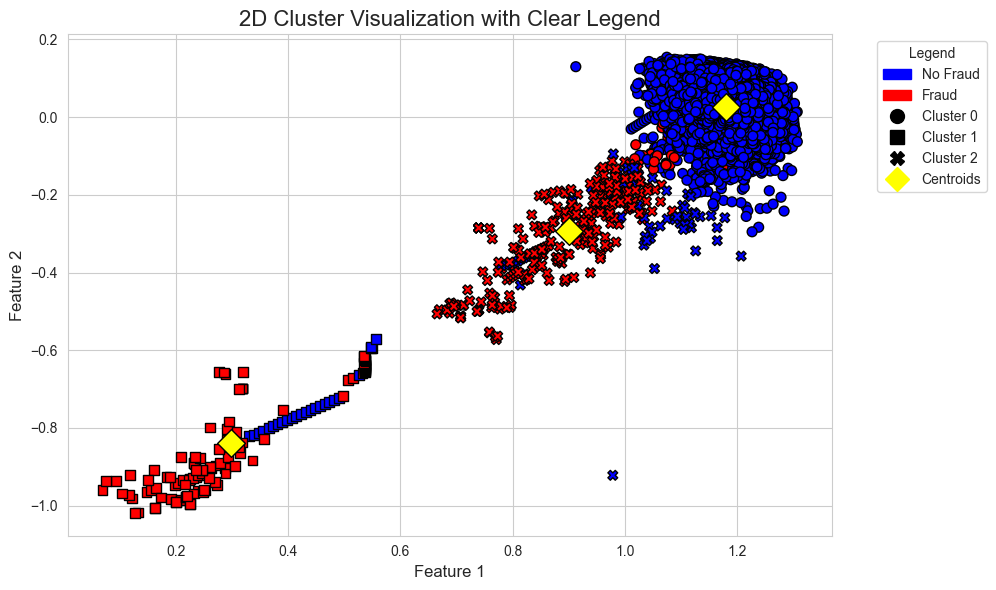

In [16]:
# test on full data
k = 3 # selected from the previous analysis
kmeans = fit_kmeans(X_train_ac, k)
full_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_full_ac)
full_kmeans_centroids = kmeans.cluster_centers_

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_ac, y, full_cluster_labels, full_kmeans_centroids)

### DBSCAN

In [17]:
# find the optimal number of clusters
eps = np.arange(0.05, 0.1, 0.005)
pca_clustering, pca_classification = score_dbscan(X_train_ac, X_test_ac, y_train, y_test, eps)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(3))
pca_classification_df.round(2)

     eps  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0  0.050     0.508      0.748      0.216    0.231     0.745     0.273
1  0.055     0.508      0.748      0.216    0.231     0.745     0.273
2  0.060     0.284      0.796      0.206    0.251     0.804     0.263
3  0.065     0.284      0.796      0.206    0.251     0.804     0.263
4  0.070     0.284      0.796      0.206    0.251     0.804     0.263
5  0.075     0.284      0.796      0.206    0.251     0.804     0.263
6  0.080     0.284      0.796      0.206    0.251     0.804     0.263
7  0.085     0.290      0.797      0.206    0.251     0.804     0.263
8  0.090     0.239      0.800      0.206    0.252     0.801     0.263
9  0.095     0.239      0.800      0.206    0.252     0.801     0.263


,eps,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,0.05,0.84,0.35,0.22,0.99,0.86,0.43,0.27,1.0
1,0.06,0.84,0.35,0.22,0.99,0.86,0.43,0.27,1.0
2,0.06,0.84,0.34,0.21,1.00,0.85,0.42,0.26,1.0
3,0.06,0.84,0.34,0.21,1.00,0.85,0.42,0.26,1.0
4,0.07,0.84,0.34,0.21,1.00,0.85,0.42,0.26,1.0
5,0.07,0.84,0.34,0.21,1.00,0.85,0.42,0.26,1.0
6,0.08,0.84,0.34,0.21,1.00,0.85,0.42,0.26,1.0
7,0.08,0.84,0.34,0.21,1.00,0.85,0.42,0.26,1.0
8,0.09,0.84,0.34,0.21,1.00,0.85,0.42,0.26,1.0
9,0.09,0.84,0.34,0.21,1.00,0.85,0.42,0.26,1.0


   accuracy    f1  recall  precision
0       1.0  0.34    0.22       0.84


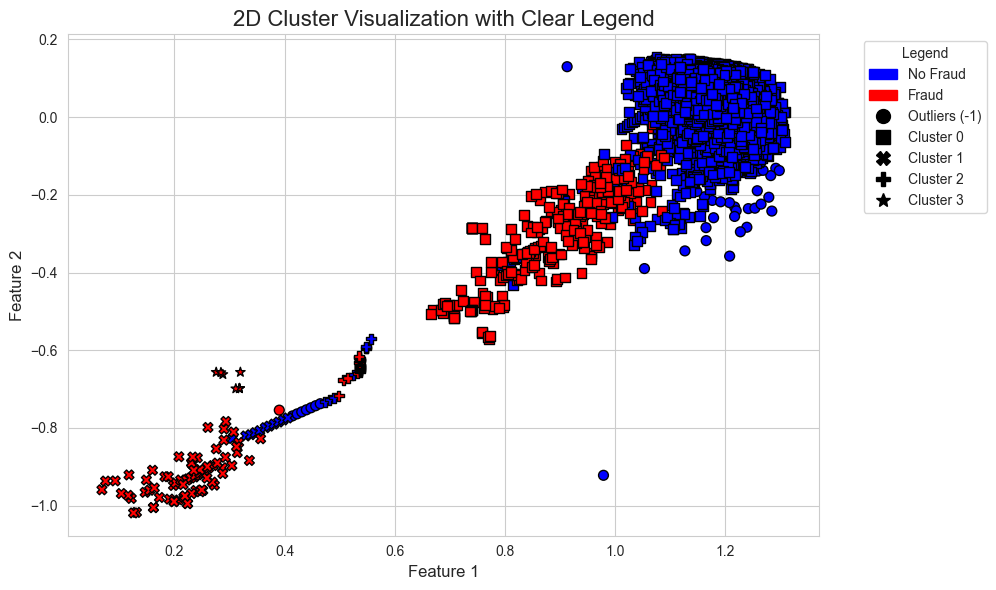

In [18]:
eps = 0.075
dbscan = fit_dbscan(X_train_ac, eps)

full_cluster_labels = test_dbscan(dbscan, X_train_ac, X_full_ac)

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_ac, y, full_cluster_labels)

### Classifier - XGBoost - Baseline

In [62]:
#Defining the XGB model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

#Define grid search for hyperparameter tuning of XGB
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.001, 0.01, 0.1, 0.2],
    "subsample": [0.8, 1, 1.2],
}
# Define Grid
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="neg_log_loss",
    cv=3,
    verbose=1
)

# Fit and use best estimator
grid.fit(X_train, y_train)
print(grid.best_params_)
best_xgb = grid.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


In [63]:
#Predictions and Threshold predictions
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

threshold = 0.9
y_pred_threshold = (y_pred_proba[:] > threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"{threshold} Threshold Classification Report:\n", classification_report(y_test, y_pred_threshold))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       400
         1.0       0.99      0.92      0.95        99

    accuracy                           0.98       499
   macro avg       0.98      0.96      0.97       499
weighted avg       0.98      0.98      0.98       499

0.9 Threshold Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       400
         1.0       0.99      0.89      0.94        99

    accuracy                           0.98       499
   macro avg       0.98      0.94      0.96       499
weighted avg       0.98      0.98      0.98       499



### Classifier - RandomForest - Baseline

In [64]:
#Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

#Define grid search for hyperparameter tuning of Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
# Define Grid for RandomForest
grid = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring="neg_log_loss",
    cv=3,
    verbose=1
)

#Fit and use best estimator
grid.fit(X_train, y_train)
print(grid.best_params_)
best_rf = grid.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [65]:
#Predictions and Threshold predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

y_pred_threshold = (y_pred_proba[:] > threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"{threshold} Threshold Classification Report:\n", classification_report(y_test, y_pred_threshold))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       400
         1.0       0.99      0.89      0.94        99

    accuracy                           0.98       499
   macro avg       0.98      0.94      0.96       499
weighted avg       0.98      0.98      0.98       499

0.9 Threshold Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       400
         1.0       1.00      0.83      0.91        99

    accuracy                           0.97       499
   macro avg       0.98      0.91      0.94       499
weighted avg       0.97      0.97      0.96       499



### Classifier - Logistic Regression - Baseline

In [70]:
log_reg = LogisticRegression(random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l2', 'l1'],       
    'solver': ['liblinear', 'saga'] 
}

grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=3,
    verbose=1
)

grid.fit(X_train, y_train)
print(grid.best_params_)
best_log_reg = grid.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [71]:
#Predictions and Threshold predictions
y_pred = best_log_reg.predict(X_test)
y_pred_proba = best_log_reg.predict_proba(X_test)[:, 1]

y_pred_threshold = (y_pred_proba[:] > threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"{threshold} Threshold Classification Report:\n", classification_report(y_test, y_pred_threshold))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       400
         1.0       0.97      0.91      0.94        99

    accuracy                           0.98       499
   macro avg       0.97      0.95      0.96       499
weighted avg       0.98      0.98      0.98       499

0.9 Threshold Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       400
         1.0       1.00      0.83      0.91        99

    accuracy                           0.97       499
   macro avg       0.98      0.91      0.94       499
weighted avg       0.97      0.97      0.96       499

